JDE
$$
F_{i,G+1}=
\begin{cases}
F_l+rand_1*F_u, &if\ rand_2\lt \tau_1\\
F_{i,G}, &otherwise
\end{cases}
$$
$$
CR_{i,G+1}=
\begin{cases}
rand_3, &if\ rand_4\lt \tau_2\\
CR_{i,G}, &otherwise
\end{cases}
$$
$$rand_j\in[0,1],\tau_1=\tau_2=0.1,F_l=0.1,F_u=0.9$$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def jde(fobj, bounds, mut=0.5, cr=0.9, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = population[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), min_b, max_b)
            cross_points = np.random.rand(dimensions) < cr
            randj = np.random.rand(4)
            if randj[0]<0.1:
                mut = 0.1+randj[1]*0.9
            if randj[2]<0.1:
                crossp = randj[3]
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, population[j])
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial  
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

SaDE策略池中四个策略,rand_1,rand_to_best_2,rand_2,current_to_rand_1
开始每个策略被选择的概率相等,在每一代对于每个策略都考虑使用这个策略生成的变异向量,这些变异向量进入下一次迭代的数量记为$ns_{k,G}$,反之记为$nf_{k,G}$,这样记录LP代，LP称为学习期。LP溢出时就删除最早的记录，将最新生成的数字再填写进去。于是再最初的LP代之后将基于成功和失败记忆在之后的每代更新选择不同策略的概率。

首先在前LP代，对于NP个个体其中一个，生成一个随机数，由随机数确定采用什么变异策略（每种策略被选择的概率暂时相等）。然后根据选择的策略执行相应的变异函数（选择几个其他个体或最优个体进行变异操作）得到变异个体，之后交叉，判断能否进入下一次迭代，记录进成功或失败表格。
在LP代之后，选择某个变异策略的概率每代都会变化，这个变化根据成功和失败的两个表格得出。（表格记得清零），然后更新表格。（取余LP）

In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


def sade(fobj, bounds, mut=0.5, cr=0.5, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    sp = strategy_probability = [0.25] * 4
    lp = learning_period = 5
    success_memory = np.zeros([lp, 4])
    failure_memory = np.zeros([lp, 4])
    cr_memory = [[],[],[],[]]
    for i in range (lp):
        for j in range (popsize):
            popj = population[j]
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c, d, e = population[np.random.choice(idxs, 5, replace = False)]
            strategy_num = -1
            mut = random.gauss(0.5, 0.3)
            cr = random.gauss(0.5, 0.1)
            if((cr < 0) or (cr > 1)):
                cr = random.gauss(0.5, 0.1)
            rand_sp = np.random.rand()
            if(rand_sp < sp[0]):
                strategy_num = 0
                trial = rand_1_bin(a, b, c, mut, min_b, max_b, popj, dimensions, cr)
            elif(rand_sp < sum(sp[:1])):
                strategy_num = 1
                trial = rand_to_best_2_bin(a, b, c, d, mut, min_b, max_b, popj, dimensions, best, cr)
            elif(rand_sp < sum(sp[:2])):
                strategy_num = 2
                trial = rand_2_bin(a, b, c, d, e, mut, min_b, max_b, popj, dimensions, cr)
            else:
                strategy_num = 3
                trial = current_to_rand_1_bin(a, b, c, popj, mut, min_b, max_b)
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                cr_memory[strategy_num].append(cr)
                success_memory[i, strategy_num] += 1
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
            else:
                failure_memory[i, strategy_num] += 1
    cr_average_0 = np.average(cr_memory[0])
    cr_average_1 = np.average(cr_memory[1])
    cr_average_2 = np.average(cr_memory[2])
    cr_average_3 = np.average(cr_memory[3])
    for i in range (its):
        success_sum = pd.DataFrame(success_memory).sum(axis = 0)
        failure_sum = pd.DataFrame(failure_memory).sum(axis = 0)
        skg = success_sum / failure_sum + 0.01
        sp = skg / sum(skg)
        success_memory[(i%lp)] = 0
        failure_memory[(i%lp)] = 0
        for j in range (popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c, d, e = population[np.random.choice(idxs, 5, replace = False)]
            strategy_num = -1
            rand_sp = np.random.rand()
            mut = random.gauss(0.5, 0.3)
            if(rand_sp < sp[0]):
                strategy_num = 0
                trial = rand_1_bin(a, b, c, mut, min_b, max_b, popj, dimensions, cr)
            elif(rand_sp < sum(sp[:1])):
                strategy_num = 1
                trial = rand_to_best_2_bin(a, b, c, d, mut, min_b, max_b, popj, dimensions, best, cr)
            elif(rand_sp < sum(sp[:2])):
                strategy_num = 2
                trial = rand_2_bin(a, b, c, d, e, mut, min_b, max_b, popj, dimensions, cr)
            else:
                strategy_num = 3
                trial = current_to_rand_1_bin(a, b, c, popj, mut, min_b, max_b)
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                success_memory[i%lp, strategy_num] += 1
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
            else:
                failure_memory[i%lp, strategy_num] += 1
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

In [6]:
def rand_1_bin(a, b, c, mut, min_b, max_b, popj, dimensions, cr):
    mutant = np.clip(a + mut * (b - c), min_b, max_b)
    cross_points = np.random.rand(dimensions) < cr
    if not np.any(cross_points):
        cross_points[np.random.randint(0, dimensions)] = True
    trial = np.where(cross_points, mutant, popj)
    return trial
def rand_to_best_2_bin(a, b, c, d, mut, min_b, max_b, popj, dimensions, best, cr):
    mutant = np.clip(popj + mut * (best - popj) + mut * (a - b) + mut * (c - d), min_b, max_b)
    cross_points = np.random.rand(dimensions) < cr
    if not np.any(cross_points):
        cross_points[np.random.randint(0, dimensions)] = True
    trial = np.where(cross_points, mutant, popj)
    return trial
def rand_2_bin(a, b, c, d, e, mut, min_b, max_b, popj, dimensions, cr):
    mutant = np.clip(a + mut * (b - c) + mut * (d - e), min_b, max_b)
    cross_points = np.random.rand(dimensions) < cr
    if not np.any(cross_points):
        cross_points[np.random.randint(0, dimensions)] = True
    trial = np.where(cross_points, mutant, popj)
    return trial
def current_to_rand_1_bin(a, b, c, popj, mut, min_b, max_b):
    k = np.random.rand()
    trial = np.clip(popj + k * (a - popj) + mut * (b - c), min_b, max_b)
    return trial

In [8]:
def Rastrigin(x):
    return sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10)
sade(Rastrigin, [(-5.12, 5.12)] * 10, mut = 0.5, cr = 0.9, popsize = 100)

<generator object sade at 0x000002BEFFC61948>

In [7]:
sp = [1,2,3,4]
print(sum(sp[:2]))

3


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def de(fobj, bounds, mut=0.5, cr=0.9, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    population = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = population[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), min_b, max_b)
            cross_points = np.random.rand(dimensions) < cr
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, population[j])
            f = fobj(trial)
            if f < fitness[j]:
                fitness[j] = f
                population[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial  
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

c:\users\oliver\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\oliver\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 1.96568188,  0.96343699, -0.06931578,  1.0022518 ,  0.03335026,
        0.07340417, -0.03094188, -1.9361066 ,  0.06972806,  0.03864428]), 14.477424335874021)


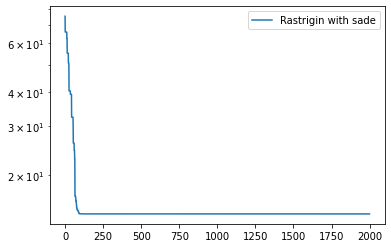

In [7]:
def Rastrigin(x):
    return sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10)
def Rastrigin_sade():
    it = list(sade(Rastrigin, [(-5.12,5.12)] * 10, mut = 0.5, cr = 0.9, popsize = 100, its = 2000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with sade')
    plt.yscale('log')
    plt.legend()
Rastrigin_sade()